## Tesina di Matematica per l'Intelligenza Artificiale
Contini Alessandro, Mele Francesca  
A.A. 2024-2025

# Analisi di un dataset sulla qualità del vino
Il dataset su cui andiamo a lavorare si trova nella libreria UCI - Machine Learning Repository e contiene informazioni relative ad alcune varianti di vino rosso e bianco del "Vinho Verde", prodotto nell'omonima regione del nord del Portogallo. Ogni dato è caratterizzato da diversi attributi (caratteristiche chimico-fisiche) e dalla qualità del vino in esame: più il valore dell'attributo 'Qualità' sarà alto, maggiore sarà la qualità del vino.

Noi ci occupiamo di analizzare soltanto il dataset sul vino rosso (i risultati che si otterrebbero analizzando anche il vino bianco sono simili, visto che entrambi contengono gli stessi attributi e i valori di ogni attributo sono dello stesso tipo)

Il dataset **winequality-red.csv** contiene 1599 osservazioni di vino rosso, ognuna descritta da 12 caratteristiche: 11 di queste sono variabili indipendenti tra loro e sono:
- _fixed acidity_ : Acidi non volatili presenti nel vino, principalmente acido tartarico. Contribuiscono alla struttura e al gusto.
- _volatile acidity_ : Acido acetico (e simili): valori alti danno un odore sgradevole, simile all'aceto.
- _citric acid_ : Acido naturale (presente negli agrumi), aggiunge freschezza e sapidità.
- _residual sugar_ : Zuccheri rimasti dopo la fermentazione. Più alto = vino più dolce.
- _chlorides_ : Contenuto salino del vino (cloruro di sodio). Troppo = gusto sgradevole.
- _free sulfur dioxide_ : SO₂ disponibile per proteggere il vino da ossidazione e batteri.
- _total sulfur dioxide_ : Totale SO₂ presente (libero + legato). Usato come conservante.
- _density_ : Densità del vino. Dipende da zuccheri e alcol.
- _pH_ : Acidità complessiva. Valori bassi = vino più acido.
- _sulphates_ : Aggiunte per migliorare la conservazione. Quantità eccessive possono alterare il gusto.
- _alcohol_ : Percentuale di alcol nel vino. Influenza aroma e corpo.

La 12° colonna delle features è quella relativa alla _quality_, descritta da un intero tra 0 e 10.

L’obiettivo è costruire un modello predittivo in grado di stimare la qualità del vino a partire dalle sue caratteristiche, e valutare quali sono le variabili più importanti per la previsione.

## Importazione del dataset e prima esplorazione
Prima di iniziare l'analisi dobbiamo importare su Python le librerie che ci serviranno per utilizzare gli algoritmi; inoltre aggiungiamo due file .py (_FisherDA_ e _linear_r2_) che ci sono stati forniti durante il corso per implementare rispettivamente MDA e SVM.

In [1]:
# Librerie
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from FisherDA import MultipleFisherDiscriminantAnalysis as MDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from linear_r2 import HyperplaneR2
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer

Andiamo dunque a leggere i dati dal file .csv e a visualizzare alcune informazioni sul dataset: notiamo che tutte le caratteristiche chimico-fisiche sono di tipo float mentre l'attributo qualità è un intero, come specificato sopra. Poichè tutte le informazioni sono di tipo numerico non è necassario fare operazioni di encoding. 

Il dataset non contiene valori nulli.

In [2]:
# Imposto uno stile per i grafici
sns.set(style="whitegrid")

# Leggo i dati
df_red = pd.read_csv('../data/winequality-red.csv', sep=';')

# Info sui dati
df_red.info()
M, N = df_red.shape
print("Red wine shape:", M, N)

# Statistiche descrittive
df_red.describe();

# Check null
df_red.isnull().sum();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
Red wine shape: 1599 12


In [3]:
# Opzione per vedere tutte le colonne (evita i "...")
pd.set_option('display.max_columns', None)

print("Prime 5 righe del dataset - Vino Rosso")
display(df_red.head())
print("Ultime 5 righe del dataset - Vino Rosso")
display(df_red.tail())

Prime 5 righe del dataset - Vino Rosso


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Ultime 5 righe del dataset - Vino Rosso


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


Andiamo a suddividere i vini in base alla qualità. Notiamo che con questa distribuzione il dataset risulta sbilanciato e le analisi sarebbero controproducenti; dobbiamo perciò trovare una suddivisione bilanciata.

In [4]:
#Conteggio qualità
df_quality = df_red['quality'].value_counts().sort_index().to_frame(name='Numero di vini')
df_quality.index.name = 'Qualità'
totale_vini = df_quality['Numero di vini'].sum()
df_quality['% Classe'] = (df_quality['Numero di vini'] / totale_vini)
display(df_quality)

,Numero di vini,% Classe
Qualità,,
3,10,0.006254
4,53,0.033146
5,681,0.425891
6,638,0.398999
7,199,0.124453
8,18,0.011257


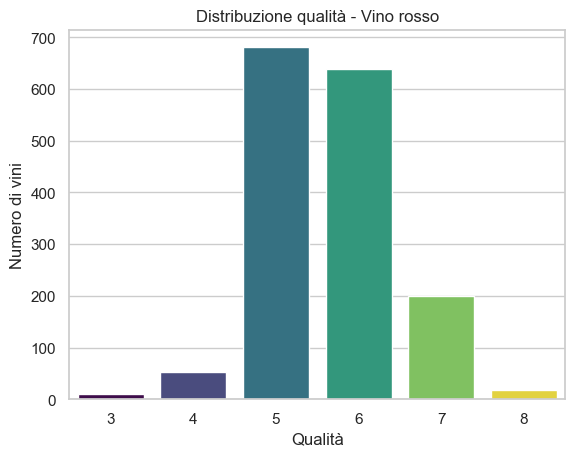

In [5]:
#Distribuzione qualità (conteggio)
sns.countplot(x='quality', data=df_red, hue='quality', palette='viridis', legend=False)
plt.title("Distribuzione qualità - Vino rosso")
plt.xlabel("Qualità")
plt.ylabel("Numero di vini")
plt.show()

Facciamo dunque una suddivisione binaria della qualità dei vini: assegnamo valore 1 ai vini considerati 'buoni' (ovvero a quelli con una qualità maggiore di 5) e 0 a quelli 'cattivi' (qualità <=5), in modo da avere il dataset bilanciato; questo migliora le prestazioni degli algoritmi di analisi che andremo a considerare.

,Numero di vini,% Classe
Qualità,,
0,744,0.465291
1,855,0.534709


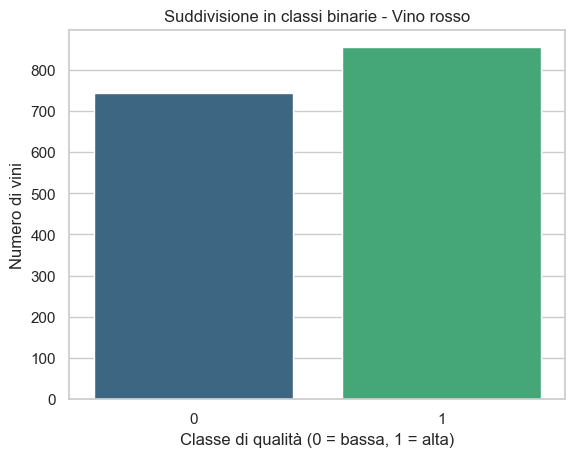

In [6]:
def quality_class(q):
    if q <= 5:
        return 0
    else:
        return 1

df_red['quality_class'] = df_red['quality'].apply(quality_class)

df_quality_class = df_red['quality_class'].value_counts().sort_index().to_frame(name='Numero di vini')
df_quality_class.index.name = 'Qualità'
totale_vini2 = df_quality_class['Numero di vini'].sum()
df_quality_class['% Classe'] = (df_quality_class['Numero di vini'] / totale_vini2)

display(df_quality_class)

# 2 – Distribuzione classi binarie
sns.countplot(x='quality_class', data=df_red, hue='quality_class', palette='viridis', legend=False)
plt.title("Suddivisione in classi binarie - Vino rosso")
plt.xlabel("Classe di qualità (0 = bassa, 1 = alta)")
plt.ylabel("Numero di vini")
plt.show()

Andiamo a visualizzare la matrice delle correlazioni tra le features:
- Le variabili più correlate positivamente con la qualità sono: alcohol, sulphates, citric acid.
- Le variabili più correlate negativamente sono: volatile acidity, density.

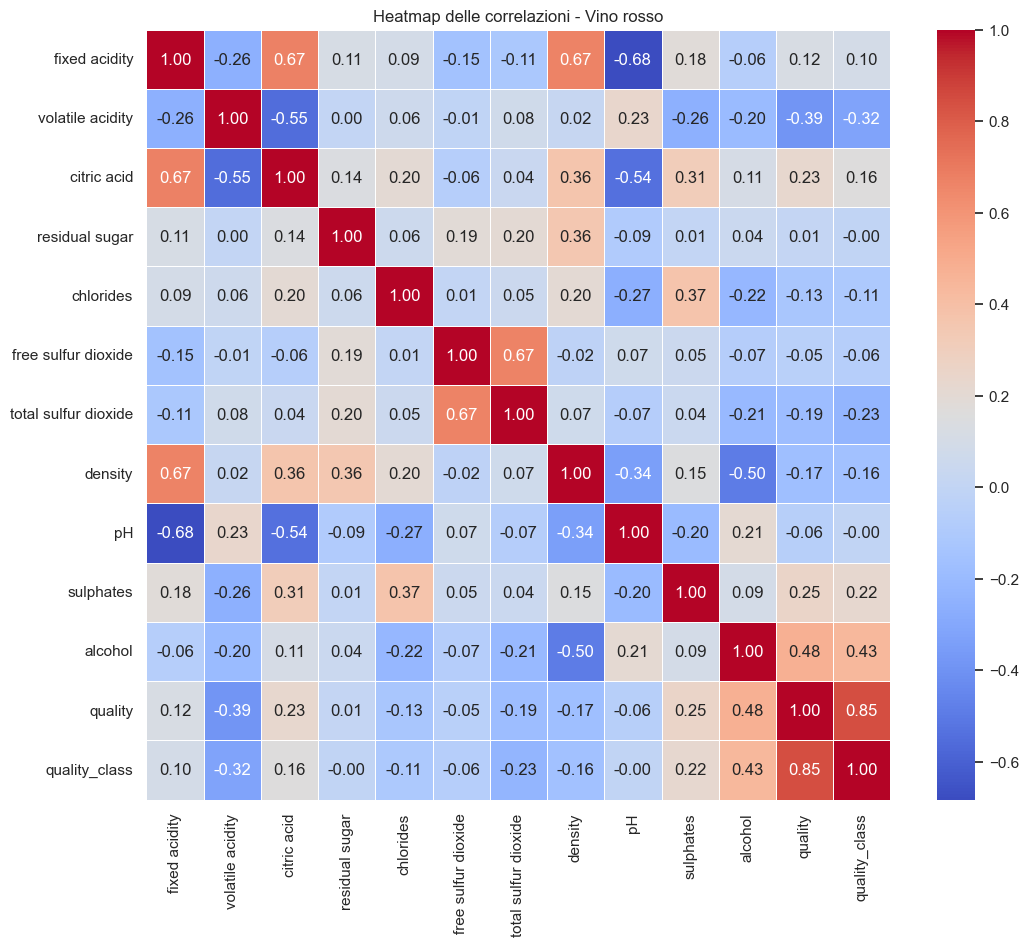

In [7]:
# Correlazioni tra variabili
plt.figure(figsize=(12,10))
sns.heatmap(df_red.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Heatmap delle correlazioni - Vino rosso")
plt.show()

## Analisi degli attributi
Andiamo ora ad analizzare quali attributi hanno una maggior influenza sui diversi valori di qualità dei vini.

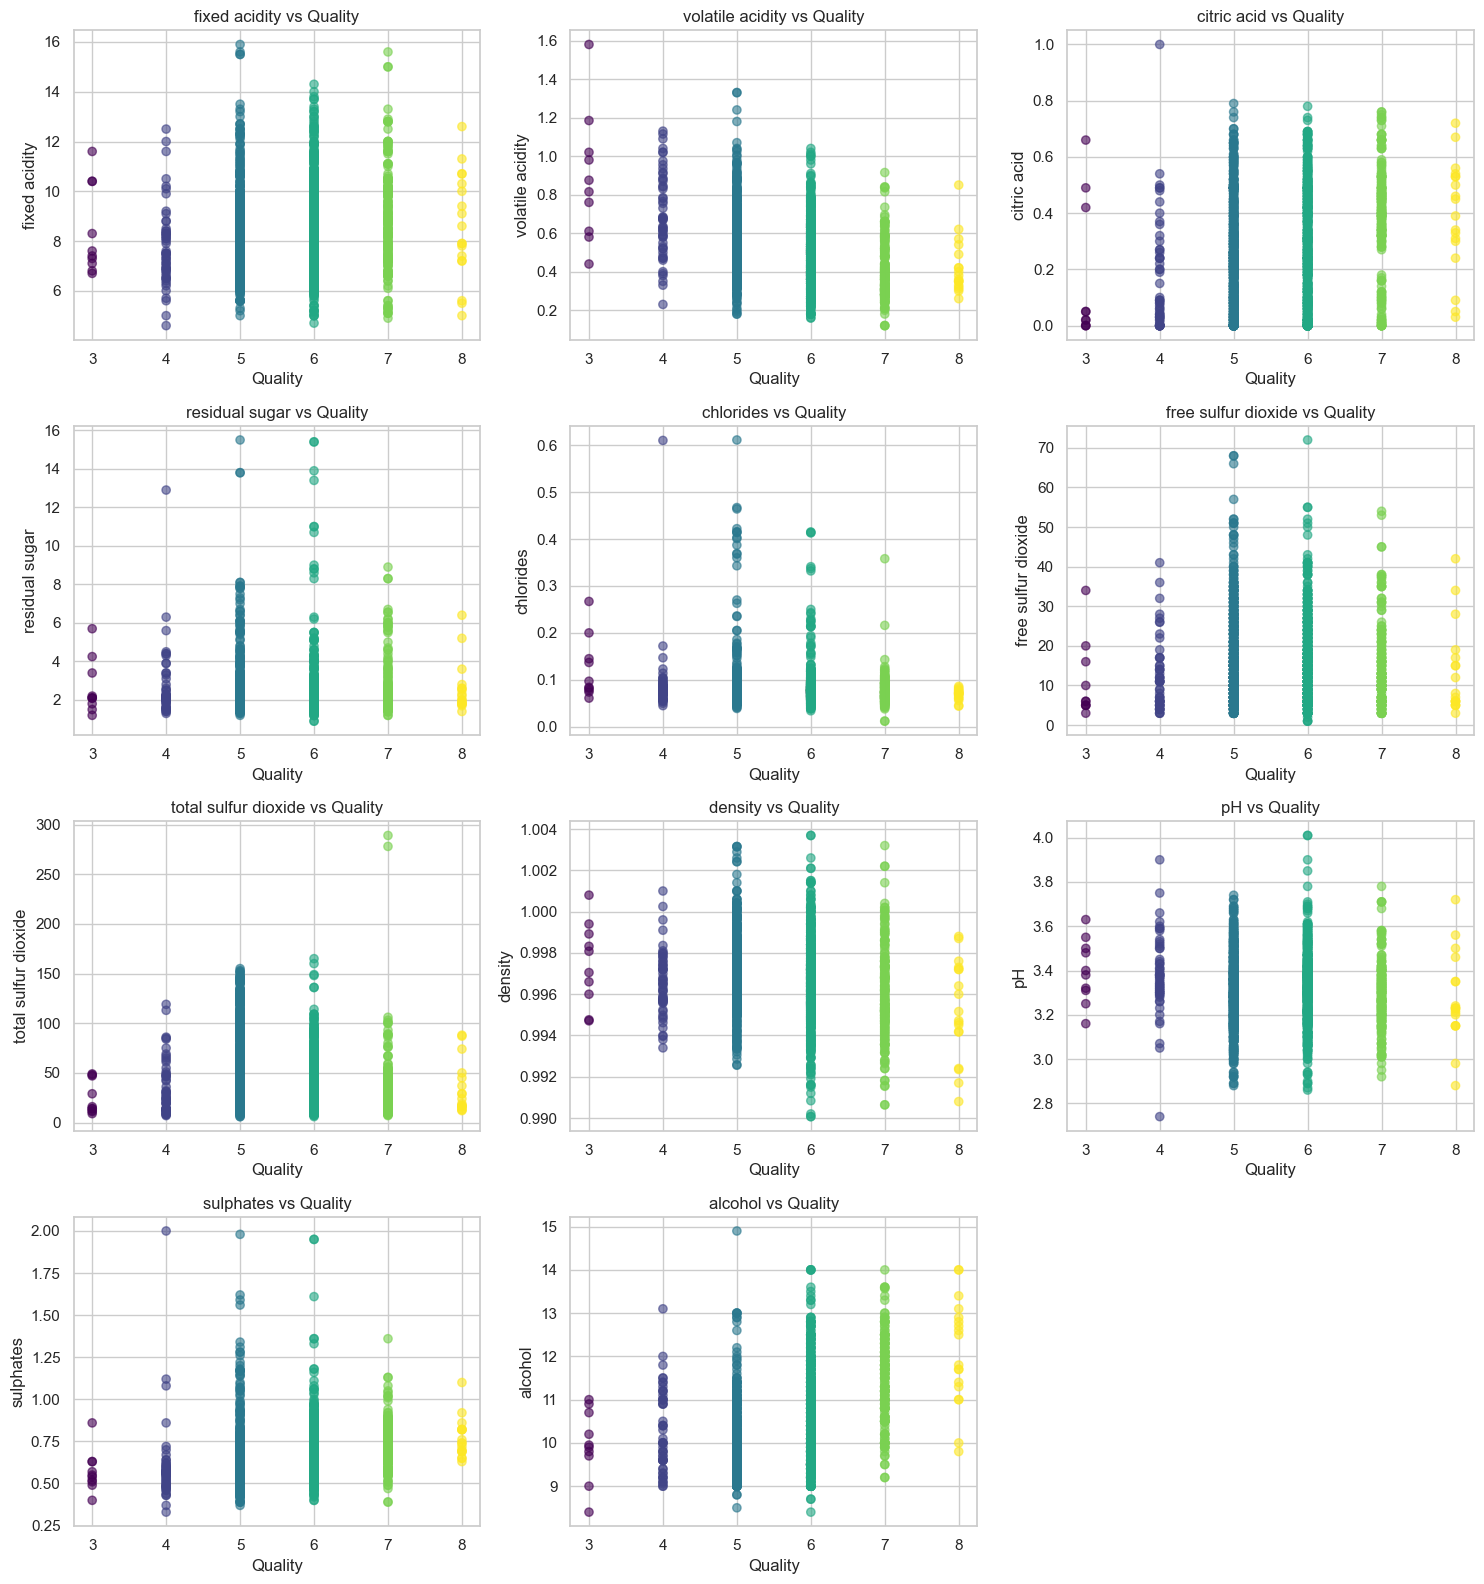

In [8]:
# Prendiamo solo le colonne numeriche
features = df_red.select_dtypes(include='number').columns.drop(['quality_class','quality'])

# Creiamo i sottoplot
n = len(features)
cols = 3
rows = (n // cols) + (n % cols > 0)

plt.figure(figsize=(cols * 5, rows * 4))

for i, col in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    plt.scatter(df_red['quality'], df_red[col], c=df_red['quality'], cmap='viridis', alpha=0.6)
    plt.title(f"{col} vs Quality")
    plt.xlabel("Quality")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


## PCA - Principal Component Analysis

In primo luogo, applichiamo l'Analisi delle Componenti Principali (PCA) al dataset df_red relativo al vino rosso, con l’obiettivo di confrontare l’effetto della standardizzazione sui risultati della PCA. L'analisi è volta a ridurre la dimensionalità del dataset e contemporaneamente mantenere sufficienti informazioni sui dati utilizzando le componenti principali.

Abbiamo un insieme di dati D = {x₁, x₂, ..., xₙ}, dove ogni xᵢ è un vettore di dimensione d.
L'obiettivo è usare la PCA per ridurre la dimensione a k.

Passaggi :

Calcola la media campionaria:
$$
\hat{\mu} = \frac{1}{n} \sum_{i=1}^n x_i
$$

Sottrai la media campionaria da ciascun vettore:
$$
z_i = x_i - \hat{\mu}
$$

Calcola la matrice di dispersione (scatter matrix):
$$
S = \sum_{i=1}^n z_i z_i^T
$$
che equivale alla matrice di covarianza n-1 volte.

Dato che S è simmetrica, definita positiva è diagonalizzabile e ha autovalori reali non negativi, si può determinare una base ortonormale di $ \mathbb{R}^n $, con gli autovalori ad essi corrispondenti.

Calcola gli autovettori e₁, e₂, ..., eₖ corrispondenti ai k autovalori più grandi della matrice S.                        Gli autovettri sono indicizzati in modo tale che i rispettivi autovalori siano ordinati in ordine decrescente.

Costruisci la matrice E formata dalle colonne e₁, ..., eₖ:
$$
E = [e_1 \; \cdots \; e_k]
$$

Ottieni la rappresentazione ridotta del dato:
$$
y = E^T z
$$

### VARIANZA SPIEGATA 
Poiché Cov(X) è diagonalizzabile come una matrice $\text{diag}(\lambda_1, \ldots, \lambda_n)$, abbiamo che le tracce di Cov(X) e $\text{diag}(\lambda_1, \ldots, \lambda_n)$ sono uguali.
Definiamo quindi la somma di tutti gli autovalori come Varianza Totale di X, poiché
$$
\Lambda := \sum_{i=1}^n \lambda_i = \sum_{i=1}^n (\text{Cov}(X))_{ii} = \sum_{i=1}^n \text{Var}(x_i).
$$

Fissato m, definiamo come varianza spiegata la somma $\sum_{i=1}^m \lambda_i$ e come percentuale di varianza spiegata la frazione $\sum_{i=1}^m \lambda_i / \Lambda$

### PCA SU WINE-DATASET
Selezioniamo le variabili indipendenti X, ed escludiamo le colonne quality e quality_class. La variabile target y è quality_class, utile per la costruzione della PCA binaria.

Inoltre dividiamo il dataset in training e test set, mantenendo la proporzione originale delle classi (stratify=y).

In [9]:
# 1. Seleziona X e y
X = df_red.drop(columns=['quality', 'quality_class'])
y = df_red['quality_class'] #usiamo quality_class per costruire una PCA binaria

# 2. Dividi in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Abbiamo poi confrontato due modelli di PCA con dati standardizzati e non, come si può vedere nel caso non standardizzato la prima componente principale spiega il 95% della varianza, rendendo superflui lo studio delle successive componenti principali.
Invece nel secondo caso possiamo osservare un andamento più regolare del grafico della varianza comulativa.

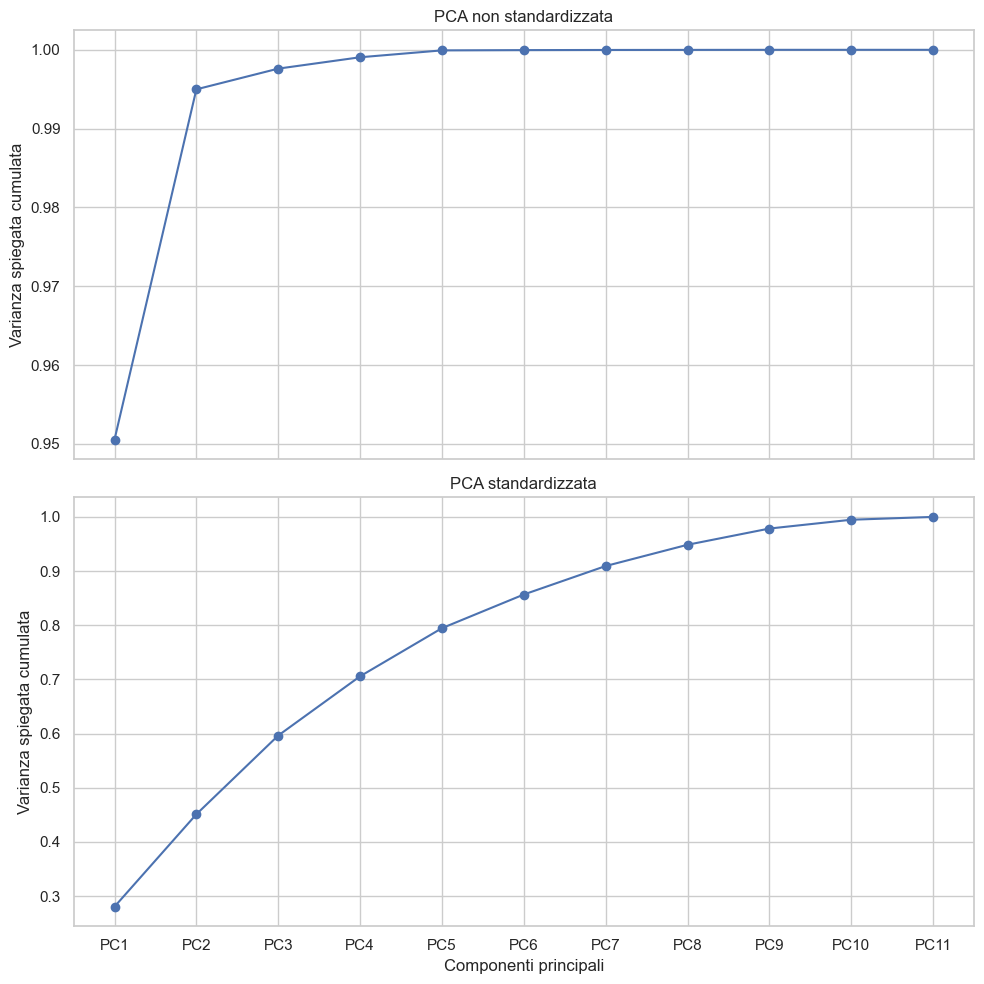

In [10]:
# 3. PCA NON standardizzata
pca_nostd = PCA()
pca_nostd.fit(X_train)

# 4. PCA STANDARDIZZATA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca_std = PCA()
X_train_pca = pca_std.fit_transform(X_train_scaled)
X_test_pca = pca_std.transform(X_test_scaled)

cumulative_var = np.cumsum(pca_nostd.explained_variance_ratio_)
cumulative_var_std = np.cumsum(pca_std.explained_variance_ratio_)

# Etichette delle componenti (PC1, PC2, ...)
component_labels = [f"PC{i+1}" for i in range(X_train.shape[1])]

# Plot doppio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Grafico 1: senza standardizzazione
axs[0].plot(component_labels, cumulative_var, marker='o')
axs[0].set_title("PCA non standardizzata")
axs[0].set_ylabel("Varianza spiegata cumulata")
axs[0].grid(True)

# Grafico 2: con standardizzazione
axs[1].plot(component_labels, cumulative_var_std, marker='o')
axs[1].set_title("PCA standardizzata")
axs[1].set_xlabel("Componenti principali")
axs[1].set_ylabel("Varianza spiegata cumulata")
axs[1].grid(True)

plt.tight_layout()
plt.show()


Ora analizziamo il comportamento della PCA con un numero di componenti necessario per spiegare almeno il 95% della varianza

In [11]:
# 5. Trovo quante componenti servono per spiegare almeno il 95% della varianza
n_components_95 = np.argmax(cumulative_var_std >= 0.95) + 1  # +1 perché gli indici partono da 0

# 6. Riepilogo in DataFrame
df_pca = pd.DataFrame({
    'val': [n_components_95, cumulative_var_std[n_components_95 - 1]]
}, index=['n. PC', 'expl. Var. (%)'])

# 7. Visualizzazione
display(df_pca)

,val
n. PC,9.000000
expl. Var. (%),0.978506


Visualizziamo con uno score Graph la rappresentazione dei dati con 2 e 3 componenti principali, 

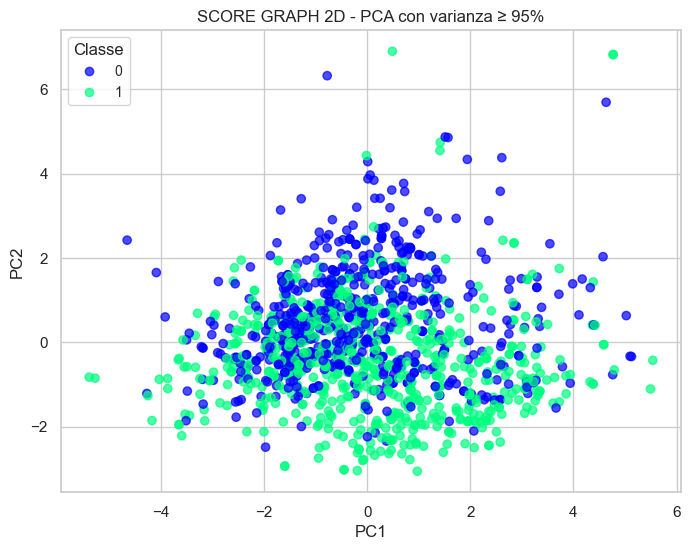

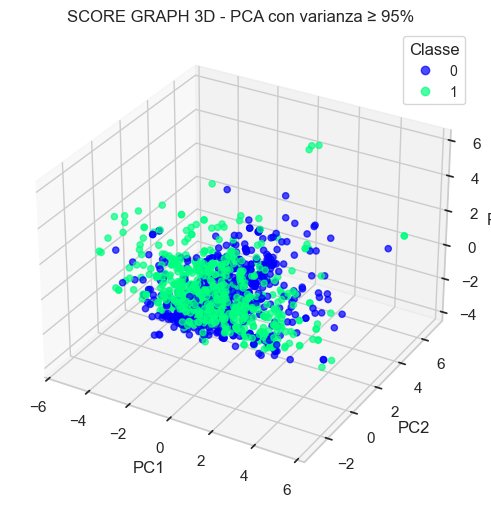

Varianza totale spiegata dalle componenti: 0.9785


In [13]:
# PCA per spiegare almeno il 95% della varianza
pca = PCA(0.95)
pca.fit(X_train_scaled)

# Proiezione nello spazio ridotto
Y_pca = pca.transform(X_train_scaled)

# Etichette della classe (usate per colorare i punti)
targets = y_train
class_labels = sorted(targets.unique())

# SCORE GRAPH 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=targets.astype('category').cat.codes, cmap='winter', alpha=0.7)
plt.title('SCORE GRAPH 2D - PCA con varianza ≥ 95%')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.legend(handles=scatter.legend_elements()[0], labels=class_labels, title='Classe', fontsize='small')
plt.show()


# SCORE GRAPH 3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(Y_pca[:, 0], Y_pca[:, 1], Y_pca[:, 2], c=targets.astype('category').cat.codes, cmap='winter', alpha=0.7)

ax.set_title('SCORE GRAPH 3D - PCA con varianza ≥ 95%')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.grid(True)

# Aggiunta legenda
plt.legend(handles=scatter.legend_elements()[0], labels=class_labels, title='Classe', fontsize='small')
plt.show()

# Varianza spiegata

print(f'Varianza totale spiegata dalle componenti: {pca.explained_variance_ratio_.sum():.4f}')


Possiamo dedurre dai vari grafici che la PCA non funziona correttamente, perchè i dati non essendo separabili linearmente sono concentrati per la maggior parte al centro del grafico.

### CONTRIBUTO DELLE PC
Rappresentiamo il contributo delle caratteristiche delle prime due componenti principali.

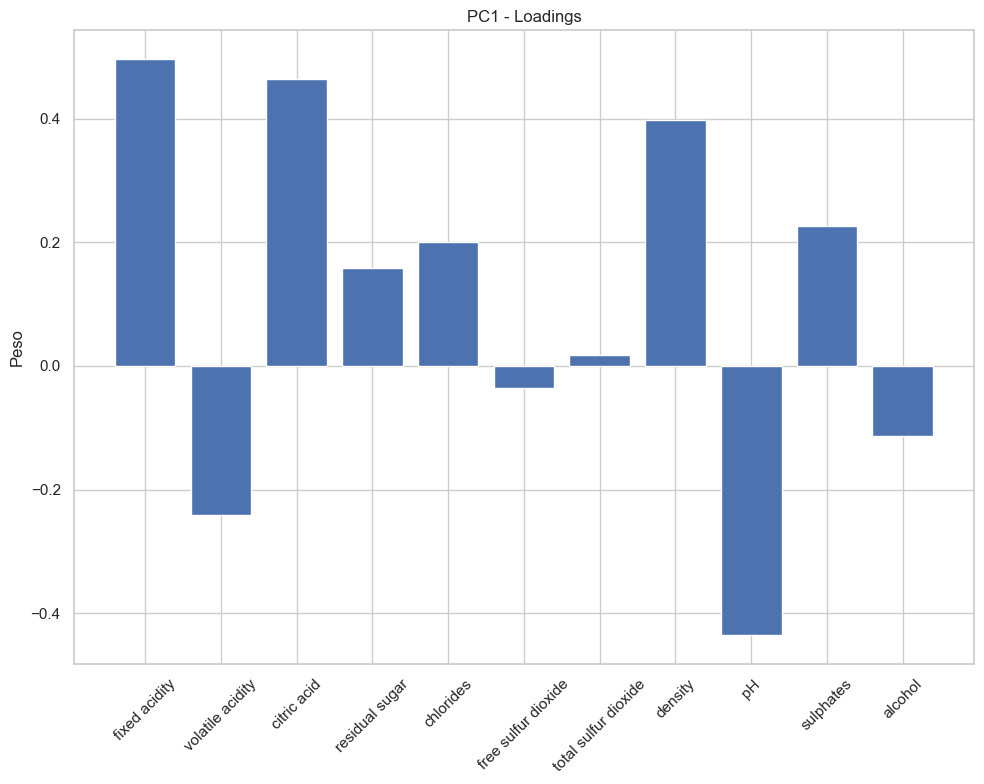

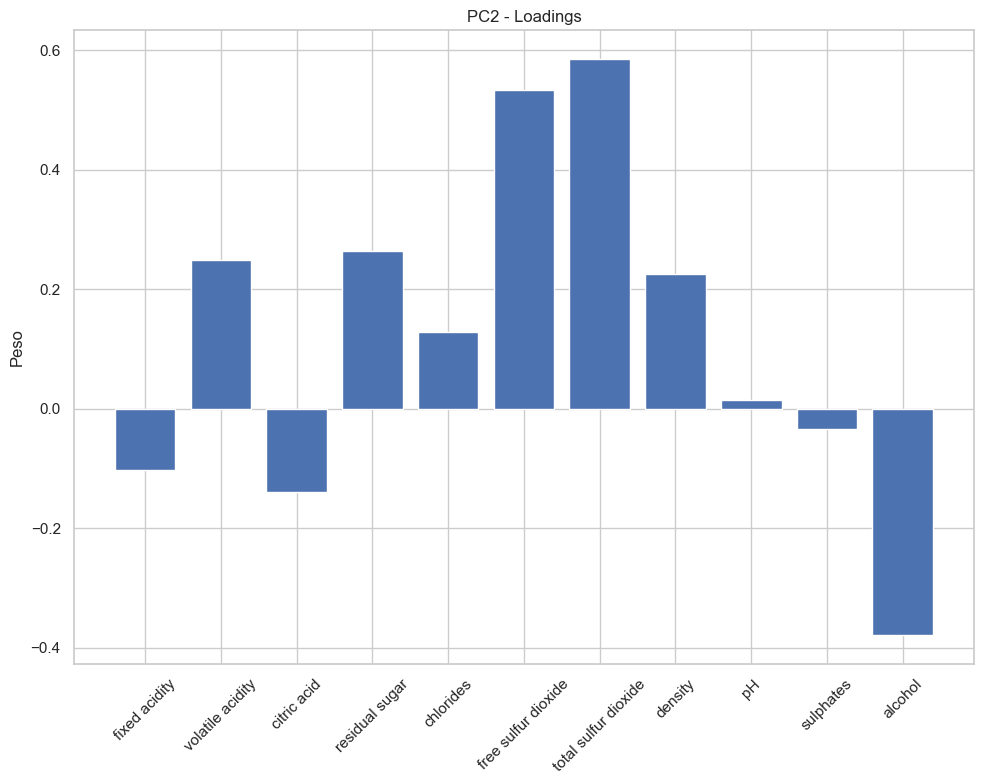

In [13]:
feature_names = features.tolist()

# Grafico dei loadings della PC1

plt.figure(figsize=(10, 8))
plt.bar(np.arange(len(feature_names)), pca.components_[0, :])
plt.xticks(ticks=np.arange(len(feature_names)),
           labels=feature_names,
           rotation=45)
plt.title('PC1 - Loadings')
plt.ylabel('Peso')
plt.grid(True)
plt.tight_layout()
plt.show()

# Grafico dei loadings della PC2

plt.figure(figsize=(10, 8))
plt.bar(np.arange(len(feature_names)), pca.components_[1, :])
plt.xticks(ticks=np.arange(len(feature_names)),
           labels=feature_names,
           rotation=45)
plt.title('PC2 - Loadings')
plt.ylabel('Peso')
plt.grid(True)
plt.tight_layout()
plt.show()


## FDA - Fisher Discriminant Analysis
La PCA (Analisi delle Componenti Principali) trova la rappresentazione dei dati più accurata in uno spazio a dimensione ridotta, e successivamente proietta i dati nelle direzioni di massima varianza. Tuttavia, le direzioni di massima varianza possono essere inutili per la classificazione.

Risulta dunque necessario utilizzare un metodo che preservi la direzione utile per la classificazione dei dati: implementiamo la FDA per soddisfare le nostre esigenze.

La FDA a differenza della MDA si utilizza quando i dati sono separati in due soli classe.

L'obbiettivo della FDA, infatti è massimizzare la separazione tra le classi dei dati. La soluzione a questo problema è data dagli m autovettori con più grandi autovalori del problema agli autovalori generalizzato: 
$$ 
S_B v = \lambda S_W v 
$$
dove:
$ S_B \in \mathbb{R}^{n \times n} $ è la between scatter matrix, di rango al più ;
$ S_W \in \mathbb{R}^{n \times n} $ è la within scatter matrix;
$ V \in \mathbb{R}^{n \times m} $ è la matrice incognita avente per colonne i vettori che generano lo spazio di dimensione 

Nello specifico, indicata con $X_j \in \mathbb{R}^{N_j \times n}$ la sottomatrice di $X \in \mathbb{R}^{N \times n}$ contenente tutti i dati appartenenti alla classe j, abbiamo che le matrici ed $ S_B $ ed $ S_W $, sono così definite: 
$$
S_W := \sum_{j=1}^{c} \bar{X}_j^T \bar{X}_j = \sum_{j=1}^{c} (X_j - \mu^{(j)T})^T (X_j - \mu^{(j)T}) \in \mathbb{R}^{n \times n}
$$
 
e

$$
S_B := \bar{M}^T \bar{M} \in \mathbb{R}^{n \times n}, \quad \bar{M} := \begin{bmatrix} \sqrt{N_1} (\mu^{(1)T} - \mu) \\ \vdots \\ \sqrt{N_c} (\mu^{(c)T} - \mu) \end{bmatrix} \in \mathbb{R}^{c \times n}
$$

Nel caso ideale in cui $ S_B $ sia invertibile, il problema consiste nel trovare gli autovettori ed autovalori della matrice 
$ S = S_W^{-1} S_B $. In particolare, per le proprietà di $ S_B $, il problema ha al più c-1 autovalori distinti e non nulli. Indicizzando gli autovalori in ordine decrescente, si identificano quindi gli autovettori v_i rappresentanti le "direzioni discriminanti di Fisher", dove la direzione è "tanto più discriminante per le classi", quanto è maggiore l'autovalore corrispondente.

Come nel caso della PCA abbiamo lavorato su dati scalati.

Per implementare il medoto ci siamo serviti del pacchetto FisherDA.py.

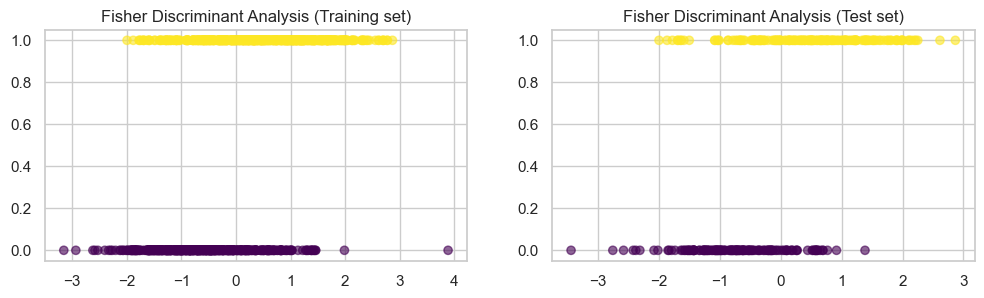

In [14]:
# FDA
fda = MDA()
fda.fit(X_train_scaled, y_train.values)

# Trasformazioni con parte reale
Zfda_train = np.real(fda.transform(X_train_scaled))
Zfda_test = np.real(fda.transform(X_test_scaled))

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

axs[0].scatter(Zfda_train[:, 0], y_train.values, c=y_train.values, cmap='viridis', alpha=0.6)
axs[0].set_title("Fisher Discriminant Analysis (Training set)")

axs[1].scatter(Zfda_test[:, 0], y_test.values, c=y_test.values, cmap='viridis', alpha=0.6)
axs[1].set_title('Fisher Discriminant Analysis (Test set)')

plt.grid(True)
plt.show()


## LDA - Linear Discriminant Analysis
Il metodo sfrutta il teorema di Bayes per identificare bordi bayesiani lineari di decisione per la classificazione di dati. Tra le ipotesi del metodo c'è il fatto di avere distribuzione delle classi che sia normale e, inoltre, l'omoschedasticità (cioè variabili aleatorie con stessa varianza).

In particolare, il metodo calcola la funzione discriminante
 
dove

 è la matrice di varianza-covarianza dei punti appartenenti alla classe . Tuttavia, per l'omoschedasticità, ;
 è la probabilità a priori di appartenere alla classe  (p.e., se probabilità uniforme, ).
La funzione discriminante altro non è che una rappresentazione della probabilità  calcolata tramite il teorema di Bayes con le ipotesi sopra citate, passando al logaritmo e scartando i termini indipendenti da . Cioè:
 
 
dove
 


,Training Set,Test Set
Accuracy,0.747459,0.75625


,Actual Class,Predicted Class,P(Class 0) - %,P(Class 1) - %
0,1,0,68.34,31.66
1,0,0,50.58,49.42
2,0,0,92.20,7.80
3,0,0,72.45,27.55
4,1,1,13.29,86.71
...,...,...,...,...
315,1,1,17.36,82.64
316,0,0,88.90,11.10
317,0,0,73.89,26.11
318,0,0,72.03,27.97


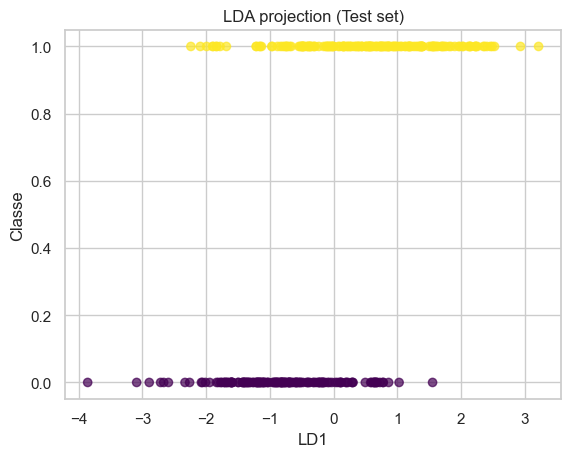

In [15]:
#LDA con 1 componente (max per 2 classi)
lda = LDA()
lda.fit(X_train_scaled, y_train)

#vettore delle classi predette
y_pred = lda.predict(X_test_scaled)
#matrice che calcola la probabilità di appartenere a ogni classe
y_pred_proba = lda.predict_proba(X_test_scaled)

y_pred_df = pd.DataFrame({'Actual Class': y_test,
                        'Predicted Class': y_pred,
                        'P(Class 0) - %': np.round(y_pred_proba[:, 0] * 100, decimals=2),
                        'P(Class 1) - %': np.round(y_pred_proba[:, 1] * 100, decimals=2)})

y_pred_df = y_pred_df.reset_index(drop=True)

#accuratezza della predizione su training e test set
scores_dict = {'Training Set': lda.score(X_train_scaled, y_train), 'Test Set': lda.score(X_test_scaled, y_test)}
scores = pd.DataFrame(scores_dict, index=['Accuracy'])
display(scores)
display(y_pred_df)

#plot
Zlda = lda.transform(X_test_scaled)
plt.scatter(Zlda, y_test, c=y_test, cmap='viridis', alpha=0.7)
plt.title("LDA projection (Test set)")
plt.xlabel("LD1")
plt.ylabel("Classe")
plt.grid(True)
plt.show()

## QDA - Quadratic Discriminant Analysis
Il metodo è analogo alla LDA, con la differenza che si considera l'eteroschedasticità per i dati (cioè variabili aleatorie con varianza diversa).

la funzione discriminante diventa quindi 
$$
\delta_k(\mathbf{x}) = -\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu}_k)^T \mathbf{S}_k^{-1} (\mathbf{x} - \boldsymbol{\mu}_k) + \log \pi_k - \frac{1}{2} \log |\mathbf{S}_k|, \quad \forall k = 1, \ldots, c.
$$

In [16]:
# Inizializzazione oggetto QDA
qda = QDA()

# "Addestramento" dell'oggetto QDA rispetto a X_train e y_train
qda.fit(X_train_scaled, y_train)

# Calcoliamo il vettore delle classi predette rispetto ai dati del test set
y_pred_q = qda.predict(X_test_scaled)
# Calcoliamo la matrice che, per ogni riga, nella colonna j indica la probabilità di appartenenza alla classe (j-1) 
y_pred_proba_q = qda.predict_proba(X_test_scaled)

# Creiamo un DataFrame (solo per estetica) da y_pred e y_pred_proba
y_pred_df_q = pd.DataFrame({'Actual Class': y_test,
                        'Predicted Class': y_pred_q,
                        'P(Class 0) - %': np.round(y_pred_proba_q[:, 0] * 100, decimals=2),
                        'P(Class 1) - %': np.round(y_pred_proba_q[:, 1] * 100, decimals=2)})

y_pred_df_q = y_pred_df_q.reset_index(drop=True)

# Calcoliamo l'accuratezza della predizione sul training e sul test set e creiamo un apposito DataFrame (solo per estetica)
scores_dict_q = {'Training Set': qda.score(X_train_scaled, y_train), 'Test Set': qda.score(X_test_scaled, y_test)}
scores_q = pd.DataFrame(scores_dict_q, index=['Accuracy'])

display(scores_q)
display(y_pred_df_q)

,Training Set,Test Set
Accuracy,0.746677,0.709375


,Actual Class,Predicted Class,P(Class 0) - %,P(Class 1) - %
0,1,0,71.04,28.96
1,0,1,44.78,55.22
2,0,0,96.90,3.10
3,0,0,55.31,44.69
4,1,1,6.73,93.27
...,...,...,...,...
315,1,1,10.13,89.87
316,0,0,99.47,0.53
317,0,1,45.10,54.90
318,0,0,66.23,33.77


## SVM - Support Vector Machines

,%. Hard,%. Soft
training,0.744332,0.73964
test,0.753125,0.73125


Text(0.5, 1.0, 'SVM SOFT - C=0.01')

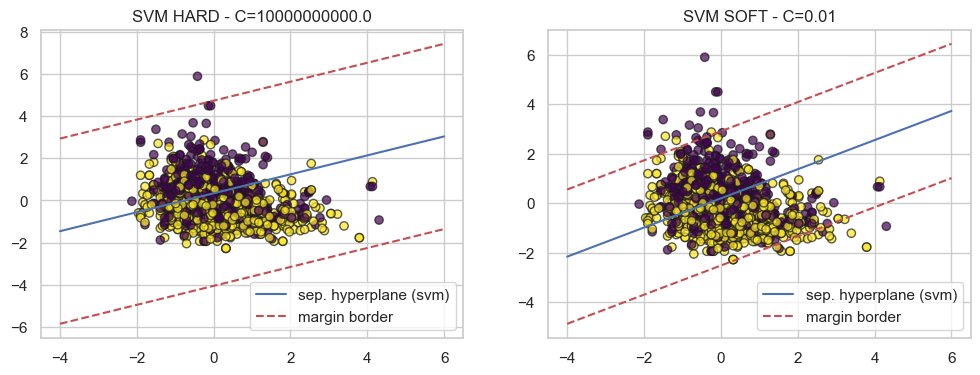

In [17]:
#SVM
#hard SVM
C_hard = 1e10
random_state = 42

# Inizializzazione SVM
lsvm_hard = LinearSVC(C=C_hard, loss='squared_hinge', dual=False, random_state=random_state)

# Addestramento SVM
lsvm_hard.fit(X_train_scaled, y_train)

# Pesi retta (iperpiano di R^2) separatrice
w_hard = lsvm_hard.coef_
b_hard = lsvm_hard.intercept_

# Inizializzazione retta separatrice
line_hard = HyperplaneR2(w_hard, b_hard)

#soft SVM
C_soft = 0.01
lsvm_soft = LinearSVC(C=C_soft, loss='hinge', dual=True, random_state=random_state)
lsvm_soft.fit(X_train_scaled, y_train)  # usa dati scalati e y_train

w_soft = lsvm_soft.coef_
b_soft = lsvm_soft.intercept_

line_soft = HyperplaneR2(w_soft, b_soft)

df_lsvm_hard_soft = pd.DataFrame({'%. Hard': [lsvm_hard.score(X_train_scaled, y_train), lsvm_hard.score(X_test_scaled, y_test)],
                             '%. Soft': [lsvm_soft.score(X_train_scaled, y_train), lsvm_soft.score(X_test_scaled, y_test)]},
                            index=['training', 'test'])
display(df_lsvm_hard_soft)

#plot a confronto
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
axs[0].plot([-4., 6.], [line_hard.line_x2(-4.), line_hard.line_x2(6.)], label='sep. hyperplane (svm)')
axs[0].plot([-4., 6.], [line_hard.margin_x2(-4.)[0], line_hard.margin_x2(6.)[0]], 'r--', label='margin border')
axs[0].plot([-4., 6.], [line_hard.margin_x2(-4.)[1], line_hard.margin_x2(6.)[1]], 'r--')
axs[0].legend()
axs[0].set_title(f'SVM HARD - C={C_hard}')
axs[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
axs[1].plot([-4., 6.], [line_soft.line_x2(-4.), line_soft.line_x2(6.)], label='sep. hyperplane (svm)')
axs[1].plot([-4., 6.], [line_soft.margin_x2(-4.)[0], line_soft.margin_x2(6.)[0]], 'r--', label='margin border')
axs[1].plot([-4., 6.], [line_soft.margin_x2(-4.)[1], line_soft.margin_x2(6.)[1]], 'r--')
axs[1].legend()
axs[1].set_title(f'SVM SOFT - C={C_soft}')

## Kernel SVM - SVM Non Lineari

In [18]:
#per utilizzare la GridSearch divido il dataset in training set, validation set e test set
#ATTENZIONE: per poter utilizzare al meglio la classe di sklearn per la gridsearch, 
#non suddivideremo il dataset direttamente in Training, Validation e Test set, ma "estrarremo" gli indici corrispondenti e determinanti tali insiemi.
random_state = 42
test_p = 0.5
val_p = 0.4
indices = np.arange(X.shape[0])

ind_trainval, ind_test = train_test_split(indices, test_size=test_p, random_state=random_state, shuffle=True)
ind_train, ind_val = train_test_split(ind_trainval, test_size=val_p, random_state=random_state, shuffle=True)

n_features = X.shape[1]

# Definizione delle liste di valori tra i quali "scorrere" per gli iper-parametri:
C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1/(n_features*i) for i in [0.5, 1, 2, 5]]
ker_list = ['rbf', 'linear', 'poly']

# Costruzione del vettore di fold per PredefinedSplit
mask_val = np.isin(ind_trainval, ind_val)
test_fold = np.where(mask_val, 0, -1)

ps = PredefinedSplit(test_fold)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced'))
])

hparameters = [
    {'svc__kernel': ker_list[-1:], 'svc__C': C_list},
    {'svc__kernel': ker_list[:-1], 'svc__C': C_list, 'svc__gamma': gamma_list}
]

svm_gs = GridSearchCV(
    estimator=pipeline,
    param_grid=hparameters,
    scoring='f1_weighted',
    return_train_score=True,
    cv=ps,
    n_jobs=-1
)

X_trainval = X.iloc[ind_trainval]
y_trainval = y.iloc[ind_trainval]
svm_gs.fit(X_trainval, y_trainval)

# Mostriamo i risultati della Gridsearch con una tabella:
gridsearch_results = pd.DataFrame(svm_gs.cv_results_)
display(gridsearch_results.sort_values(['rank_test_score'], ascending=True))  # Mostra dalla migliore alla peggiore

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__kernel,param_svc__gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
25,0.012770,0.0,0.004328,0.0,1.00,rbf,0.045455,"{'svc__C': 1, 'svc__gamma': 0.0454545454545454...",0.751240,0.751240,0.0,1,0.818641,0.818641,0.0
11,0.011888,0.0,0.005552,0.0,0.25,rbf,0.018182,"{'svc__C': 0.25, 'svc__gamma': 0.0181818181818...",0.741972,0.741972,0.0,2,0.772187,0.772187,0.0
17,0.010469,0.0,0.004627,0.0,0.50,rbf,0.045455,"{'svc__C': 0.5, 'svc__gamma': 0.04545454545454...",0.741963,0.741963,0.0,3,0.810304,0.810304,0.0
15,0.007719,0.0,0.005796,0.0,0.50,rbf,0.090909,"{'svc__C': 0.5, 'svc__gamma': 0.09090909090909...",0.741961,0.741961,0.0,4,0.824896,0.824896,0.0
7,0.011534,0.0,0.008335,0.0,0.25,rbf,0.090909,"{'svc__C': 0.25, 'svc__gamma': 0.0909090909090...",0.738860,0.738860,0.0,5,0.810303,0.810303,0.0
9,0.009299,0.0,0.009150,0.0,0.25,rbf,0.045455,"{'svc__C': 0.25, 'svc__gamma': 0.0454545454545...",0.738860,0.738860,0.0,5,0.791461,0.791461,0.0
39,0.015899,0.0,0.004532,0.0,4.00,rbf,0.090909,"{'svc__C': 4, 'svc__gamma': 0.0909090909090909...",0.735754,0.735754,0.0,7,0.862325,0.862325,0.0
19,0.005048,0.0,0.004553,0.0,0.50,rbf,0.018182,"{'svc__C': 0.5, 'svc__gamma': 0.01818181818181...",0.735745,0.735745,0.0,8,0.791423,0.791423,0.0
21,0.004391,0.0,0.008468,0.0,1.00,rbf,0.181818,"{'svc__C': 1, 'svc__gamma': 0.1818181818181818...",0.735745,0.735745,0.0,8,0.856014,0.856014,0.0
23,0.011495,0.0,0.004774,0.0,1.00,rbf,0.090909,"{'svc__C': 1, 'svc__gamma': 0.0909090909090909...",0.735743,0.735743,0.0,10,0.831128,0.831128,0.0


In [19]:
X_train = X.iloc[ind_train]
y_true_train = y.iloc[ind_train]

X_val = X.iloc[ind_val]
y_true_val = y.iloc[ind_val]

X_test = X.iloc[ind_test]
y_true_test = y.iloc[ind_test]

# Ri-addestramento della miglior SVM (NECESSARIO A CAUSA DI REFIT)
svm_gs.best_estimator_.fit(X_train, y_true_train)

y_pred_train = svm_gs.best_estimator_.predict(X_train)
y_pred_val = svm_gs.best_estimator_.predict(X_val)
y_pred_test = svm_gs.best_estimator_.predict(X_test)

acc_train = svm_gs.best_estimator_.score(X_train, y_true_train)
prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

acc_val = svm_gs.best_estimator_.score(X_val, y_true_val)
prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

acc_test = svm_gs.best_estimator_.score(X_test, y_true_test)
prec_test = precision_score(y_true_test, y_pred_test, average='weighted')
rec_test = recall_score(y_true_test, y_pred_test, average='weighted')
f1_test = f1_score(y_true_test, y_pred_test, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc_test], 
                        'Precision': [prec_train, prec_val, prec_test], 
                        'Recall': [rec_train, rec_val, rec_test],
                        'F1': [f1_train, f1_val, f1_test]
                       },
                      index=['training', 'validation', 'test'])

cmat = confusion_matrix(y_true_test, y_pred_test, labels=svm_gs.best_estimator_.classes_)
cmat_norm_true = confusion_matrix(y_true_test, y_pred_test, labels=svm_gs.best_estimator_.classes_, normalize='true')  # recall_confusion_matrix
cmat_norm_pred = confusion_matrix(y_true_test, y_pred_test, labels=svm_gs.best_estimator_.classes_, normalize='pred')  # precision_confusion_matrix

df_cmat = pd.DataFrame(cmat, columns=['bad','good'], index=['bad','good'])
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=['bad','good'], index=['bad','good'])
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=['bad','good'], index=['bad','good'])

display(df_perf)
display(df_cmat)
display(df_cmat_norm_true)
display(df_cmat_norm_pred)

,Accuracy,Precision,Recall,F1
training,0.818372,0.820972,0.818372,0.818641
validation,0.750000,0.757214,0.750000,0.751240
test,0.723750,0.724714,0.723750,0.723824


,bad,good
bad,285,101
good,120,294


,bad,good
bad,0.738342,0.261658
good,0.289855,0.710145


,bad,good
bad,0.703704,0.255696
good,0.296296,0.744304


## MLP - Multi Layer Perceptrons

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.152568,0.036399,0.003173,0.001916,relu,0.00010,"(128,)","{'mlp__activation': 'relu', 'mlp__alpha': 0.00...",0.676592,0.741497,0.795034,0.737707,0.048428,1
3,0.158995,0.020902,0.001748,0.000053,relu,0.00001,"(128,)","{'mlp__activation': 'relu', 'mlp__alpha': 1e-0...",0.676592,0.741497,0.795034,0.737707,0.048428,1
2,0.277866,0.047504,0.001999,0.000026,relu,0.00010,"(256, 128)","{'mlp__activation': 'relu', 'mlp__alpha': 0.00...",0.685177,0.735030,0.777412,0.732540,0.037696,3
5,0.189344,0.021633,0.001641,0.000125,relu,0.00001,"(256, 128)","{'mlp__activation': 'relu', 'mlp__alpha': 1e-0...",0.685177,0.731072,0.777412,0.731220,0.037655,4
1,0.176493,0.010268,0.002454,0.000760,relu,0.00010,"(128, 64)","{'mlp__activation': 'relu', 'mlp__alpha': 0.00...",0.673259,0.735484,0.779512,0.729418,0.043589,5
4,0.129735,0.011991,0.001827,0.000052,relu,0.00001,"(128, 64)","{'mlp__activation': 'relu', 'mlp__alpha': 1e-0...",0.673259,0.735484,0.779512,0.729418,0.043589,5


,Accuracy,Precision,Recall,F1
Train+val Set,0.75970,0.759700,0.75970,0.75970
Test Set,0.70875,0.708791,0.70875,0.70828


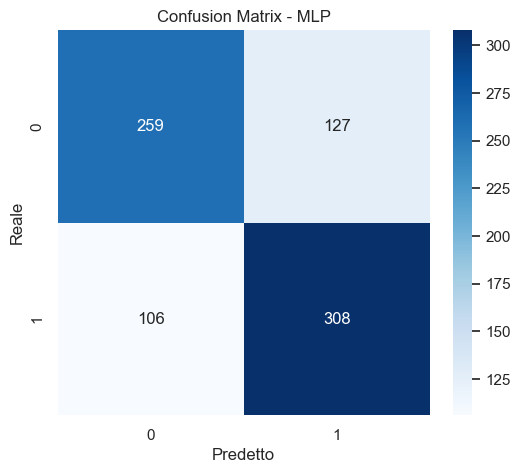

In [20]:
# Parametri
hidden_layer_sizes = (128,64) 
activation = 'relu'
batch_size = 128
patience = 50
max_epochs = 200
random_state = 42

# Costruzione pipeline
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        early_stopping=True,
        n_iter_no_change=patience,
        max_iter=max_epochs,
        validation_fraction=0.2,
        solver='adam',
        verbose=False,
        random_state=random_state,
        batch_size=batch_size
    ))
])

# Parametri da passare alla GridSearch (con prefisso 'mlp__')
param_grid = {
    'mlp__hidden_layer_sizes': [(128,), (128, 64), (256, 128)],
    'mlp__alpha': [0.0001, 0.00001],
    'mlp__activation': ['relu']
}

# GridSearch
mlp_gs = GridSearchCV(mlp_pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
mlp_gs.fit(X_trainval, y_trainval)

grid_results = pd.DataFrame(mlp_gs.cv_results_)
display(grid_results.sort_values(['rank_test_score'], ascending=True))  # Mostra dalla migliore alla peggiore

# Miglior modello
best_mlp = mlp_gs.best_estimator_
best_mlp.fit(X_train, y_true_train)
y_pred_trainval = best_mlp.predict(X_trainval)
y_pred = best_mlp.predict(X_test)

# Valutazione
acc_trainval = best_mlp.score(X_trainval, y_trainval)
prec_trainval = precision_score(y_trainval, y_pred_trainval, average='weighted')
rec_trainval = recall_score(y_trainval, y_pred_trainval, average='weighted')
f1_trainval = f1_score(y_trainval, y_pred_trainval, average='weighted')

acc = best_mlp.score(X_test, y_true_test)
prec = precision_score(y_true_test, y_pred, average='weighted')
rec = recall_score(y_true_test, y_pred, average='weighted')
f1 = f1_score(y_true_test, y_pred, average='weighted')

# Tabella performance
df_perf = pd.DataFrame({
    'Accuracy': [acc_trainval, acc],
    'Precision': [prec_trainval, prec],
    'Recall': [rec_trainval, rec],
    'F1': [f1_trainval, f1]
}, index=['Train+val Set', 'Test Set'])

display(df_perf)

# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - MLP')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()